# Generating Synthetic Wind Power Time Series

In [13]:
import os
import yaml
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [14]:
def load_config(config_path):
    with open(config_path, "r") as file:
        return yaml.safe_load(file)

In [25]:
config_path = "config.yaml"
config = load_config(config_path)

dir = config['data']['final_data']
params = config['synth']

adj_params = config['adjustable_wind_params']

In [26]:
files = os.listdir(dir)
file = files[0]

df = pd.read_csv(os.path.join(dir, file))
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
#df['timestamp'] = df['timestamp'].dt.tz_localize("UTC").dt.tz_convert("Europe/Berlin")
df.drop(['  QN_x', '  QN_y', '  QN'], axis=1, inplace=True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79200 entries, 2023-05-26 00:00:00 to 2024-11-25 23:50:00
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   STATIONS_ID    79200 non-null  int64  
 1   PP_10          79200 non-null  float64
 2   TT_10          79200 non-null  float64
 3   TM5_10         79200 non-null  float64
 4   RF_10          79200 non-null  float64
 5   TD_10          79200 non-null  float64
 6   FF_10          79200 non-null  float64
 7   DD_10          79200 non-null  int64  
 8   DS_10          79200 non-null  float64
 9   GS_10          79200 non-null  float64
 10  SD_10          79200 non-null  float64
 11  LS_10          79200 non-null  int64  
 12  Stationshoehe  79200 non-null  float64
 13  geoBreite      79200 non-null  float64
 14  geoLaenge      79200 non-null  float64
dtypes: float64(12), int64(3)
memory usage: 9.7 MB


### Saturation state

Since not all vapor quantities mix with the non-condensing gas, three states must be distinguished:

- <b>Unsaturated</b>: Only the gas phase, namely the gas-vapor mixture, is present. The partial pressure of the vapor $ p_w $ is lower than the saturation vapor pressure $ p_s $. With the partial pressure of the gas $ p_g $ the total pressure can be determined with $ p = p_g + p_d $.
  
- <b>Saturated</b>: In the gas-vapor mixture the condensation begings. The partial pressure of the vapor is equal to saturation vapor pressure $ p_s = p_w $ . 
  
- <b>Over saturated</b>: There are gas and condensate phases, whereby the gas phase (the gas-vapor mixture) is saturated. The relationships of the saturated state apply to the gas phase.

### Composition of moist air

A distinction is made between absolute and relative humidity, whereby both measure the the H<sub>2</sub>O in the vapor phase.

<b>Absolute humidity</b>: Only with respect to the vapor, fog or ice fog is not considered. The absolute humidity is identical with the partial density of water vapor $ \varrho_d $:

$ \varrho_w = \frac{m_w}{V_{Mi}} = \frac{p_w}{R_{H_20}T}$, 

where 
- $ m_w $ is the mass of the water vapor,
- $ V_{Mi} $ is the volume of the gas mixture,
- $ R_{H_2O} $ is the specific gas constant for water,
- $ T $ is the temperature of the mixture.

In the saturated state $ p_s = p_d $ it is the saturation parital density $ \varrho_s $:

$ \varrho_s = \frac{p_s}{R_{H_20}T}$.

### Relative humidity $ \phi $ 
is defined as:

$ \phi = \frac{\varrho_w}{\varrho_s} = \frac{p_{w}}{p_s} $

with:
- $ \phi $: Relative humiditiy 
- $ p_w $: Partial pressure of water vapor in the air (Pa)
- $ p_s $: Saturation vapor pressure (Pa)

The saturation vapor pressure $ p_s $ is the maximal partial pressur for the water at given temperature $ T $. A higher $ p_s $ is not possible, because the additional water will condense to liquid or disublimate to solid water (ice). 

Relative humidity $ \phi $ can take numerical values in the range $ 0 \leq \phi \leq 1 $. That means:

- $ \phi = 0 $ is dry air,
- $ \phi < 1 $ is unsaturated moist air,
- $ \phi = 1 $ is saturated moist air ($ m_{kon} = 0 $)
- $ \phi = 1 $ is oversaturated moist air ($ m_{kon} > 0 $).


### Get air density from air pressure, temperature and relative humidity

Since we need the density of the air, we need to determine the pressure and gas constant values for the mixture of dry air and water vapor.

The air density is therefore dependent from the partial density of the water vapor $ \varrho_w $ and the partial density of the dry air denoted as $ \varrho_g $, where $ g $ stands for gas.

$ \rho = \varrho_g + \varrho_w = \frac{p_g}{R_gT} + \frac{p_w}{R_{H_2O}T} $

where $ R_g $ is the specific gas constant for dry air.

The specific gas constants are given with:

- $ R_g = 287.05 \frac{J}{kgK} $
- $ R_{H_2O} = 461.5 \frac{J}{kgK} $

The partial water vapor pressure is given by first calculating the saturation vapor pressure (Huang, 2018):
https://journals.ametsoc.org/view/journals/apme/57/6/jamc-d-17-0334.1.xml

$ p_s = \exp\left(34.4942 - \frac{4924.99}{t + 237.1}\right) \cdot (t + 105)^{1.57} (t > 0°C) $

$ p_s = \exp\left(43.4942 - \frac{6545.8}{t + 278}\right) \cdot (t + 868)^{-2} (t \leq 0°C) $

With the relative humidity the partial water vapor pressure can be determined:

$ p_w = \phi * p_s $

The remaining variable $ p_g $ is calculated by subtracting $ p_g $ from the air pressure $ p $:

$ p_g = p - p_w $


### Extrapolate wind speed at hub height
https://ieeexplore.ieee.org/abstract/document/8255215

There are different methods to extrapolate the wind speed at hub height in the literature.

<b>The log-linear law</b> is based on the Monin-Obukhov similarity theory, it is a physical model stating that the wind velocity at a determined height $ h_2 $ can be calculated by:

$ v_2 = v_1 \cdot \frac{\ln\left(\frac{h_2}{z_0}\right) - \psi_m\left(\frac{h_2}{L}\right)}{\ln\left(\frac{h_1}{z_0}\right) - \psi_m\left(\frac{h_1}{L}\right)} $

- $v_2$: Wind speed to be calculated at the height $h_2$ (m/s).
- $v_1$: Wind speed measured at anemometer height $h_1$ (m/s).
- $h_2$: Target height where the wind speed is to be calculated (m).
- $h_1$: Height of the anemometer where the wind speed is measured (m).
- $z_0$: Roughness length, describing the influence of surface roughness on the wind profile (m).
- $\psi_m$: Monin-Obukhov stability function, accounting for atmospheric stability.
- $L$: Monin-Obukhov length (m), representing the thermal and dynamic properties of the atmospheric boundary layer.

But in engineering studies, the log-linear law is difficult to use for estimating vertical wind profile at a wind turbine height, among others because Monin-Obukhov stability function is dependend on the temperature difference between the heights, which is often not known.

In the case of neutral stability ($ \psi_m = 0 $), the log-linear law can be simplifies to the widely used logarithmic law which depends only on $ z_0 $ and is valid near the ground over relatively flat terrain (the lower 30-50 m), but not over complex and rough terrain (Gualtieri, 2011, 2015):

$ v_2 = v_1 \cdot \frac{\ln\left(\frac{h_2}{z_0}\right)}{\ln\left(\frac{h_1}{z_0}\right)} $

<b>The power law</b> is generally used (Tizgui, 2017).

Let $ v_1 $ be the measurement of the wind speed at height $ h_1 $ and $ v_2 $ be the wind speed at height $ h_2 $:

$ \frac{v_2}{v_1} = (\frac{h_2}{h_1})^{\alpha} $

where $ \alpha $ is the Hellmann (or friction) exponent, also known as the power exponent, depending in wind speed, atmospheric stability, land features, height and surface roughness (Gualtieri, 2011).

It is obtained empirically (Schallenberg-Rodriguez, 2013). 

It has no phyiscal basis and its validity is generally limited to the lower atmosphere (up to 150-200 m).

<b>Estimating alpha</b>

There are different methods to estimate $ \alpha $, but the most used is C. G. Justus et al. (1976):

$ \alpha = \frac{0.37 - 0.0881 \ln(v_1)}{1 - 0.0881 \ln\left(\frac{h_1}{10}\right)} $

They have shown graphically that for $ v \geq 10 \frac{m}{s} $ the exponent $ \alpha $ is closely to 0.14 = 1/7.

Is is often supposed for neutral stability (high wind) cases in flat terrain. 

H. Nfaoui et al. (1998) have taken into account various values of the roughness for various types of terrain, they have opted for the following expression:</br>
https://www.sciencedirect.com/science/article/pii/S0038092X98000401#:~:text=The%20wind%20characteristics%20of%2011,production%20by%20installing%20wind%20farms.

$ \alpha = \frac{x - 0.0881 \ln(v_1)}{1 - 0.0881 \ln\left(\frac{z_0}{10}\right)} $

where $ x $ can be determined by the following tables:

| Type of terrain                                | z₀ (m)  |
|------------------------------------------------|---------|
| Flat: beach, ice, snow landscape, ocean       | 0.005   |
| Open: law grass, airports, empty crop land    | 0.03    |
| High grass, low crops                         | 0.10    |
| Rough: tall row crops, low woods              | 0.25    |
| Very rough: forests, orchards                 | 0.50    |
| Closed: villages, suburbs                     | 1       |
| Towns: town centres, open spaces in forests   | >2      |

</br>

| z₀ (m)        | x    |
|---------------|------|
| 0.000 - 0.005 | 0.25 |
| 0.005 - 0.050 | 0.31 |
| 0.050 - 0.500 | 0.37 |
| 0.500 - 4.000 | 0.48 |

In [36]:
def get_v2(v1: float,
           params: dict
          ):
    
    """
    Calculate the wind speed (v2) using different methods.

    Parameters:
    -----------
    v1 : float
        Wind speed at measurement height in m/s
    params : float
        Dictionary with neccesary parameters
        params['h1']: Height of measurements in m
        params['h2']: Hub height in m
        params['method']: Height of measurement in m
            The method used to calculate v2. Options are:
            - 'terrain_types': Uses the terrain type to determine roughness length (z₀).
            - 'seven_power': A default method using the 1/7 power law.
            If no method is provided, the default 'seven_power' is used.
        params['terrain']: Hub height in m
            Specifies the type of terrain when `method='terrain_types'`. Valid options are:
            - 'flat': Beach, ice, snow landscape, ocean
            - 'open': Law grass, airports, empty crop land
            - 'high_grass': High grass, low crops
            - 'rough': Tall row crops, low woods
            - 'very_rough': Forests, orchards
            - 'closed': Villages, suburbs
            - 'towns': Town centres, open spaces in forests

    Returns:
    --------
    v2 : float
        The calculated wind speed at height h2.
    """
    method = params['v2_method']
    terrain = params['terrain']
    h1 = params['h1']
    h2 = params['h2']
    if method == 'terrain':
        terrain_types = {
            'flat': 0.005,
            'open': 0.03,
            'high_grass': 0.1,
            'rough': 0.25,
            'very_rough': 0.5,
            'closed': 1,
            'towns': 2
        }
        
        z0 = terrain_types[terrain]
        if 0.000 <= z0 <= 0.005:
            x = 0.25
        elif 0.005 < z0 <= 0.050:
            x = 0.31
        elif 0.050 < z0 <= 0.500:
            x = 0.37
        elif 0.500 < z0 <= 4.000:
            x = 0.48
        
        alpha = (x - 0.0881 * math.log(v1)) / (1 - 0.0881 * math.log(z0 / 10))
    elif method == 'seven_power':
        alpha = 1/7
    else:
        alpha = 1/7 # 'seven_power'
    v2 = v1 * (h2 / h1) ** alpha
    return v2
    
def get_rho(data: pd.DataFrame,
            params: dict,
            p_model: str = 'improved_magnus') -> pd.Series:
    air_pressure = data[params['pressure']['param']]
    temperature = data[params['temperature']['param']]
    relhum = data[params['relhum']['param']]
    # check if relative humidity is in the range between 0 and 1
    if relhum.max() > 1:
        relhum /= 100
    R_dry = 287.05  # Spezifische Gaskonstante für trockene Luft (J/(kg·K))
    R_w = 461.5  # Spezifische Gaskonstante für Wasserdampf (J/(kg·K))
    temperature_kelvin = temperature + 273.15 
    if p_model == 'huang':
        p_s = np.where(
            temperature > 0,
            np.exp(34.494 - (4924.99 / (temperature + 237.1))) / (temperature + 105) ** 1.57,
            np.exp(43.494 - (6545.8 / (temperature + 278))) / (temperature + 868) ** 2
        )
    elif p_model == 'improved_magnus':
        p_s = np.where(
            temperature > 0,
            610.94 * np.exp((17.625 * temperature) / (temperature + 243.04)),
            611.21 * np.exp((22.587 * temperature) / (temperature + 273.86))
    )
    p_w = relhum * p_s
    p_g = air_pressure - p_w
    rho_g = p_g / (R_dry * temperature_kelvin)
    rho_w = p_w / (R_w * temperature_kelvin)
    rho = rho_g + rho_w
    return rho


def generate_wind_power(data: pd.DataFrame,
                        params: dict
                        ) -> pd.Series:
    
    rated_power = params['rated_power']
    Cp = params['Cp']
    rotor_diameter = params['rotor_diameter']
    cut_in_speed = params['cut_in_speed']
    rated_speed = params['rated_speed']
    cut_out_speed = params['cut_out_speed']
    
    rho = data['rho']
    wind_speed_hub = data['v_wind_hub']
    rotor_area = np.pi * (rotor_diameter / 2) ** 2
    wind_power = np.where(
        wind_speed_hub < cut_in_speed, 0,
        np.where(
            wind_speed_hub <= rated_speed,
            0.5 * rho * rotor_area * Cp * wind_speed_hub ** 3,
            np.where(
                wind_speed_hub <= cut_out_speed,
                rated_power,
                0
            )
        )
    )
    return pd.Series(wind_power, index=data.index)


def plot_power_and_feature(data: pd.DataFrame,
                           params: dict,
                           day: str, 
                           feature: dict,
                           power: pd.Series,
                           save_fig=False): 
    day = pd.Timestamp(day)
    index_0 = power.index.get_loc(day)
    index_1 = power.index.get_loc(day + pd.Timedelta(days=1))
    feature_specs = params[feature]
    series = data[feature_specs['param']]
    feature_name = feature_specs['name']
    unit = feature_specs['unit']
    date = str(series.index[index_0:index_1][0].date())
    fig, ax1 = plt.subplots(figsize=(10, 6))
    fontsize = 14
    lines = []
    # plot power
    line1, = ax1.plot(
    power[index_0:index_1],
    label="Power Output (W)",
    color="black",
    linewidth=2.0
    )
    lines.append(line1)
    # configure secondary y-axis
    ax1.set_xlabel("Time", fontsize=fontsize)
    ax1.set_ylabel("Power Output (W)", fontsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize)
    ax1.tick_params(axis='x', labelsize=fontsize-2)
    ax2 = ax1.twinx()
    # plot feature
    line, = ax2.plot(
        series[index_0:index_1],
        label=f"{feature_name} {unit}",
        linestyle='--',
        #color='blue',
        linewidth=2.0
    )
    lines.append(line)
    # configure primary y-axis
    ax2.set_ylabel(f"{feature_name} ({unit})", fontsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)
    # Format x-axis to show only hours (HH)
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1)) 
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ticks = ax1.get_xticks()
    ax1.set_xticks(ticks[1:-1])
    # legend
    lines.append(lines.pop(0))
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper left", fontsize=fontsize)
    plt.title(f"{feature_name} and Power Output on {date}", fontsize=fontsize)
    fig.tight_layout()
    #plt.grid(True)
    if save_fig:
        save_path = f'figs/{feature_name}'
        os.makedirs(save_path, exist_ok=True)
        save_file = os.path.join(save_path, f'{date}.png')
        plt.savefig(save_file, dpi=300)
        plt.close()
    else:
        plt.show()

In [37]:
wind_speed_hub = get_v2(v1=df[params['v_wind']['param']],
                        params=adj_params)

rho = get_rho(data=df,
              params=params,
              p_model=adj_params['p_model'])

df['rho'] = rho
df['v_wind_hub'] = wind_speed_hub

power = generate_wind_power(data=df, params=adj_params)

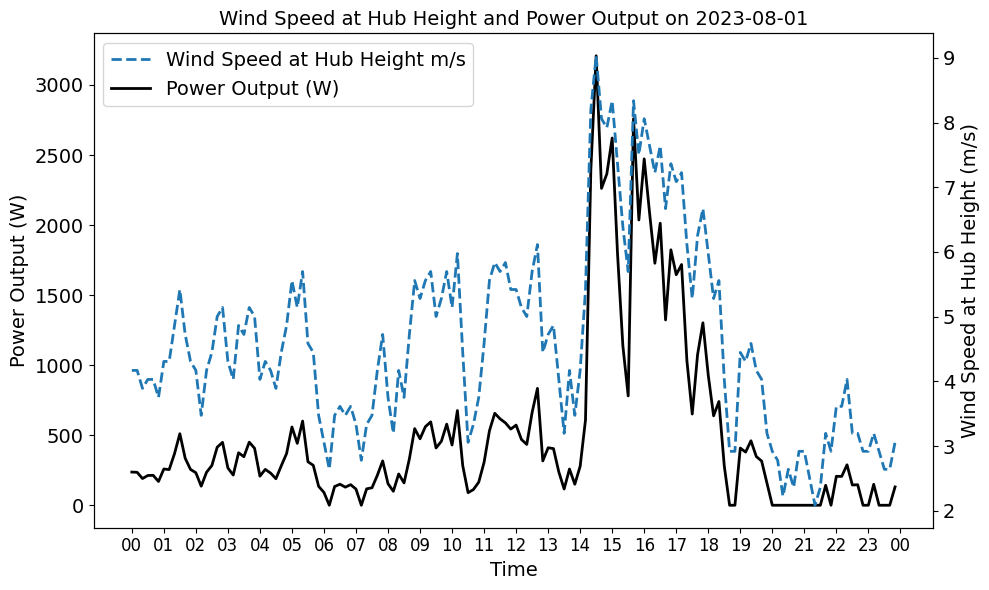

In [38]:
day = '2023-08-01'
feature='v_wind_hub'
plot_power_and_feature(data=df,
                        params=params,
                        day=day,
                        feature=feature,
                        power=power)      